In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
import random

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# dowload_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# dowload_folder_paths = [os.path.join(download_save_path, item) for item in dowload_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# # 载入变量完整的mat文件
# complete_mat_list = ['Tail_653_5/653200212291431.mat', 'Tail_660_5/660200210081101.mat','Tail_686_1/686200105101854.mat']
# complete_mat = loadmat(os.path.join(download_save_path, complete_mat_list[0]))

In [3]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

all_var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}

# give the primary classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "ABRK", "NSQT",
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", "TH", 
                       "TAS", "CASM", "GS",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = [
                   "FADS", 
                   
                   "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL",
                   "LGDN"]
var_group_control = ["HDGS", "PTRM", 
                     "RUDP", "CCPC", "CCPF", "CWPC", "CWPF",
                     "SNAP", 
                     "GPWS", "SHKR", "FADF"]
var_group_external = ["ALT", "WS", "WD", "PT", "TAT",
                      "LOC"]
var_group_recorder = ["PH"
                     ]
var_group_unclassified = ["EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "SMKB"]

primary_var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}

# 给定数据不完整的变量列表
invalid_var_dict = {'mechanism': ['FLAP', 'SPLG', 'SPLY', 'BPGR_1', 'BPGR_2', 'BPYR_1', 'BPYR_2', 'MSQT_1', 'MSQT_2', 'NSQT', 'BLV', 'CALT', 'PACK', 'WOW', 'AOA1', 'AOA2', 'GLS', 'PTCH', 'ROLL', 'TH', 'MH', 'TAS', 'CASM', 'GS', 'IVV', 'FPAC', 'CTAC'], \
                    'power': ['N2_1', 'N2_2', 'N2_3', 'N2_4', 'ECYC_1', 'ECYC_2', 'ECYC_3', 'ECYC_4', 'EHRS_1', 'EHRS_2', 'EHRS_3', 'EHRS_4', 'VIB_1', 'VIB_2', 'VIB_3', 'VIB_4', 'FADS', 'HYDG', 'HYDY', 'N1_1', 'N1_2', 'N1_3', 'N1_4', 'N1T', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'FQTY_1', 'FQTY_2', 'FQTY_3', 'FQTY_4', 'OIP_1', 'OIP_2', 'OIP_3', 'OIP_4', 'OIPL', 'EGT_1', 'EGT_2', 'EGT_3', 'EGT_4', 'LGDN', 'LGUP'], \
                        'control': ['CRSS', 'HDGS', 'A_T', 'APFD', 'DFGS', 'FGC3', 'PUSH', 'TCAS', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF', 'PLA_1', 'PLA_2', 'PLA_3', 'PLA_4', 'SNAP', 'TMODE', 'EAI', 'TAI', 'WAI_1', 'WAI_2', 'APUF', 'FADF', 'FIRE_1', 'FIRE_2', 'FIRE_3', 'FIRE_4', 'MW', 'POVT', 'SHKR', 'SMOK', 'TOCW'], \
                            'external': ['ALT', 'ALTR', 'WS', 'WD', 'PI', 'PS', 'PT', 'SAT', 'TAT', 'DA', 'TRK', 'TRKM', 'LOC', 'LATP'], \
                                'recorder': ['DWPT', 'PH', 'GMT_HOUR', 'GMT_MINUTE', 'GMT_SEC'], \
                                    'unclassified': ['ATEN', 'EVNT', 'HF1', 'HF2', 'VHF1', 'VHF2', 'VHF3', 'LMOD', 'VMODE', 'MACH', 'MNS', 'MRK', 'N1C', 'N1CO', 'SMKB']}

valid_var_dict = {group_name: list(set(all_var_groups_dict[group_name]) - set(invalid_var_dict[group_name])) for group_name in all_var_groups_dict.keys()}

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_list in var_dict.items():
        group_lens_dict[group_name] = len(var_list)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

In [17]:
def generateDataArray(mat, var_dict):
    # 初始化解释变量和响应变量的存储array
    explain_var_array, response_wshr_array = [], []

    # 分别读取自变量和WSHR因变量
    response_wshr_array = mat["WSHR"][0][0][0]

    # for group_name, var_list in all_var_groups_dict.items():
    for group_name, var_list in var_dict.items():
        for var_name in var_list:
            # 对每个变量按照rate进行下采样或过采样
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            if var_rate == 1:
                explain_var_array.append(var_data)
            else: # 进行重采样
                explain_var_array = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]

    explain_var_array = np.squeeze(np.array(explain_var_array)).T
    response_wshr_array = np.array(response_wshr_array).ravel()

    # print(explain_var_array.shape)
    # print(response_wshr_array.shape)

    return explain_var_array, response_wshr_array


# 使用随机森林进行变量重要性排序
def RFConstruction(mat, var_dict, top_k):
    # 创建随机森林分类器
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # 生成数据
    explain_var_array, response_wshr_array = generateDataArray(mat, var_dict)

    # 拟合模型
    rf.fit(explain_var_array, response_wshr_array)

    # 获取特征重要性并排序输出
    feature_importances = rf.feature_importances_
    importances_indices = np.argsort(feature_importances)[::-1]

    # print("Top", top_k, "Features:")
    # for i in range(top_k):
    #     print(f"{i+1}. Feature {importances_indices[i]}: {find_var_name(importances_indices[i], var_dict)} ({feature_importances[importances_indices[i]]})")
    
    return feature_importances, importances_indices

# 选择前 k 个重要性最高的特征
top_k = 163 

# 初始化数据存储矩阵
feature_importances_array = []
importances_indices_array = []

# 规定数据存储路径
rf_save_path = '../result/variable_evaluate/rf'
if not os.path.exists(rf_save_path):
    os.mkdir(rf_save_path)

for e_mat_name in os.listdir(exception_folder_paths[0]):
    # 读取一个异常mat文件
    e_mat_path = os.path.join(exception_folder_paths[0], e_mat_name)
    e_mat = loadmat(e_mat_path)
    feature_importances, importances_indices = RFConstruction(e_mat, all_var_groups_dict, top_k)
    feature_importances_array.append(feature_importances)
    importances_indices_array.append(importances_indices)

feature_importances_array = np.array(feature_importances_array)
importances_indices_array = np.array(importances_indices_array)

np.save(os.path.join(rf_save_path, 'feature_importances_array.npy'), feature_importances_array)
np.save(os.path.join(rf_save_path, 'importances_indices_array.npy'), importances_indices_array)

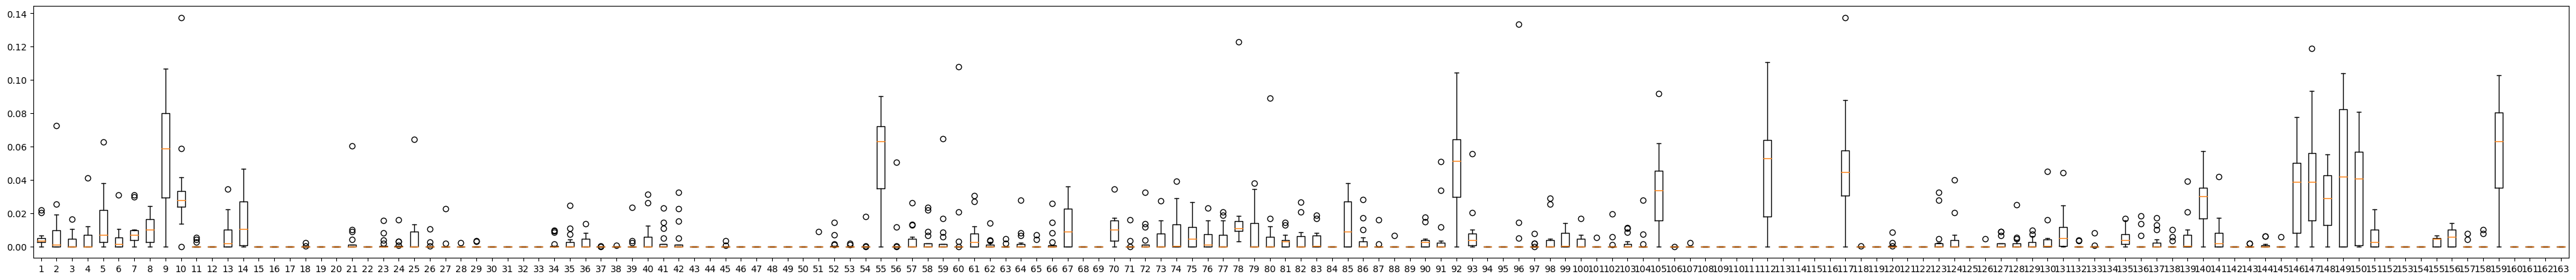

In [21]:
# 打印各变量在异常数据集中的重要性分布
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 5))
plt.boxplot(feature_importances_array)
plt.show()

In [ ]:
# 可视化
import matplotlib.pyplot as plt

def visualImportance(feature_importances, top_k, var_dict):
    varname_list = [find_var_name(importances_indices[i], var_dict) for i in range(top_k)]
    importances_list = [feature_importances[importances_indices[i]] for i in range(top_k)]

    plt.figure(figsize=(10, 10))
    plt.plot(importances_list, color="red")
    # plt.xticks(range(len(varname_list)), varname_list, rotation=45)
    plt.xlabel('variable name')
    plt.ylabel('importance score')
    plt.title('Importance ranking -- all invalid variables')
    for i in range(len(varname_list)):
        plt.text(i, importances_list[i], f"{round(importances_list[i],3)}", fontsize=8)
    plt.show()

visualImportance(feature_importances, top_k, invalid_var_dict)